In [1]:
#import all packages needed
import torch
torch.set_default_dtype(torch.float64) #keep more precision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import os
import math

%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
import random

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from numpy import genfromtxt

from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from numpy import arcsinh as arcsinh
from torchvision import models
from pathlib import Path
from tqdm import tqdm

import pandas as pd
from functools import partial
from torchsummary import summary
print(torch.__version__)

2.3.0+cu121


In [2]:
#fix seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(0)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
#mount to drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Dataset

In [5]:
#visualize data helper function
def visualize(X,ind):
  '''
  X: image numpy array
  ind: list of indexes
  '''
  fig1=plt.figure(figsize=(8,8))

  for i in range(16):
      plt.subplot(4, 4, i + 1)
      plt.axis("off")
      example_indices = int(ind[i])
      example_image = np.squeeze(X[example_indices:(example_indices + 1), 0:1]) #change band by switching 0:1 to 1:2 or 2:3
      plt.imshow(example_image, aspect='auto', cmap='viridis')

In [6]:
ls /content/gdrive/MyDrive/deepskies

paxnorm_target.npy       pax_source.npy           pax_target.npy
pax_source_metadata.csv  pax_target_metadata.csv


In [10]:
### replace link with the location of where you stored the dataset ###
#source data
data = np.load('/content/gdrive/MyDrive/deepskies/paxnorm_source.npy')
data_source = np.load('/content/gdrive/MyDrive/deepskies/paxnorm_source.npy').squeeze()
#source parameter to estimate data
metadata_source = pd.read_csv("/content/gdrive/MyDrive/deepskies/pax_source_metadata.csv")
Y_source = metadata_source['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()

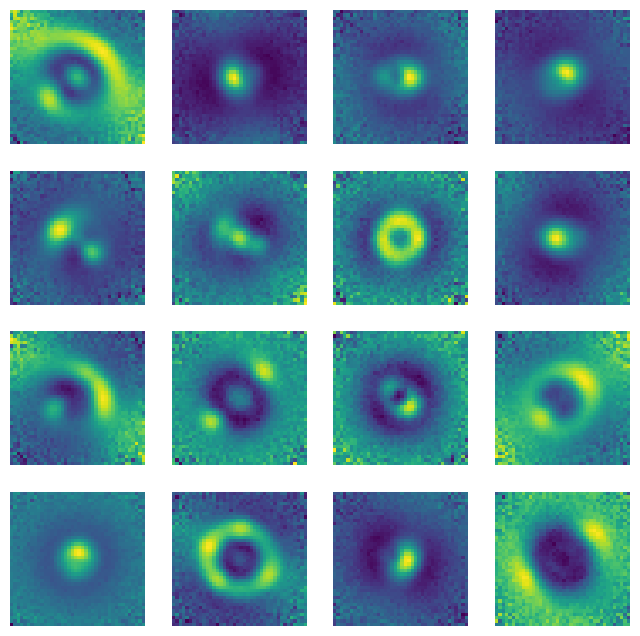

In [11]:
visualize(data, np.arange(16))

In [14]:
#target data
data_t = np.load('/content/gdrive/MyDrive/deepskies/paxnorm_target.npy')
data_target = np.load('/content/gdrive/MyDrive/deepskies/paxnorm_target.npy').squeeze()

metadata_target = pd.read_csv("/content/gdrive/MyDrive/deepskies/pax_target_metadata.csv")
Y_target = metadata_target['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()

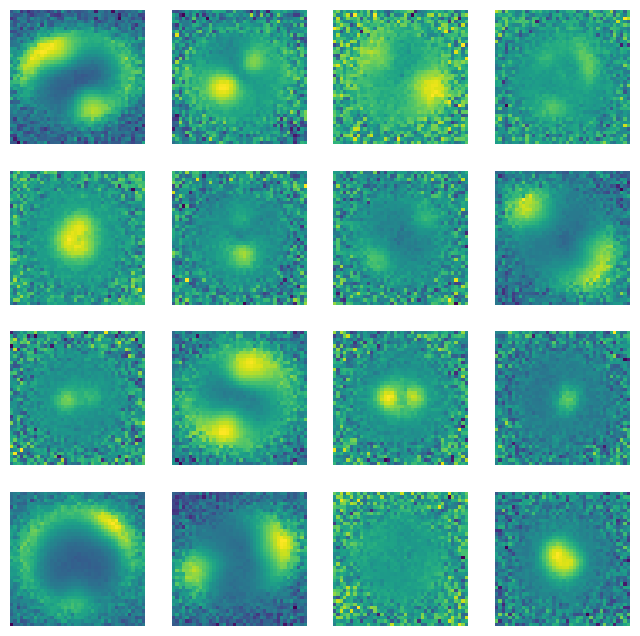

In [15]:
visualize(data_t, np.arange(16))

In [16]:
#split data

Xs_train, Xs_split, ys_train, ys_split = train_test_split(data_source, Y_source, test_size=0.33, random_state=42, shuffle=True)
Xt_train, Xt_split, yt_train, yt_split = train_test_split(data_target, Y_target, test_size=0.33, random_state=42, shuffle=True)
Xs_valid, Xs_test, ys_valid, ys_test = train_test_split(Xs_split, ys_split, test_size=0.66, random_state=42, shuffle=True)
Xt_valid, Xt_test, yt_valid, yt_test = train_test_split(Xt_split, yt_split, test_size=0.66, random_state=42, shuffle=True)


In [17]:
def data_process(X, y):
  #to tensor
  X = torch.tensor(X)
  y = torch.tensor(y)
  #to cuda
  X.cuda()
  y.cuda()
  #load dataset
  dataset = TensorDataset(X, y)
  return dataset

In [18]:
#pytorch dataloader
dataloader_source_train = DataLoader(dataset=data_process(Xs_train, ys_train), batch_size=256, shuffle=True, num_workers = 0)
dataloader_source_test = DataLoader(dataset=data_process(Xs_test, ys_test), batch_size=128, shuffle=True, num_workers = 0)
dataloader_source_valid = DataLoader(dataset=data_process(Xs_valid, ys_valid), batch_size=128, shuffle=True, num_workers = 0)
dataloader_target_train = DataLoader(dataset=data_process(Xt_train, yt_train), batch_size=256, shuffle=True, num_workers = 0)
dataloader_target_test = DataLoader(dataset=data_process(Xt_test, yt_test), batch_size=128, shuffle=True, num_workers = 0)
dataloader_target_valid = DataLoader(dataset=data_process(Xt_valid, yt_valid), batch_size=128, shuffle=True, num_workers = 0)

CNN

In [19]:
class NoDANeuralNetwork(nn.Module):
    def __init__(self):
        super(NoDANeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=32*5*5, out_features=120)
        self.fc2 = nn.Linear(120, 1)

    def forward(self, x):
        x = x.view(-1, 1, 40, 40)

        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))

        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1)
        return x

NoDAmodel = NoDANeuralNetwork().float()
NoDAmodel = NoDAmodel.cuda()

summary(NoDAmodel, (1, 40, 40));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]             208
       BatchNorm2d-2            [-1, 8, 40, 40]              16
         MaxPool2d-3            [-1, 8, 20, 20]               0
            Conv2d-4           [-1, 16, 20, 20]           1,168
       BatchNorm2d-5           [-1, 16, 20, 20]              32
         MaxPool2d-6           [-1, 16, 10, 10]               0
            Conv2d-7           [-1, 32, 10, 10]           4,640
       BatchNorm2d-8           [-1, 32, 10, 10]              64
         MaxPool2d-9             [-1, 32, 5, 5]               0
           Linear-10                  [-1, 120]          96,120
           Linear-11                    [-1, 1]             121
Total params: 102,369
Trainable params: 102,369
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [20]:
class DANeuralNetwork(nn.Module):
    def __init__(self):
        super(DANeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32*5*5, 120)
        self.fc2 = nn.Linear(120, 1)


    def forward(self, x):
        x = x.view(-1, 1, 40, 40)
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))

        x = x.view(-1, 32*5*5)
        #note difference from NoDA network: x is embedding i.e. before entering fully connected layer. This is used in MMD calculations
        y = F.relu(self.fc1(x))
        y = F.relu(self.fc2(y))
        y = y.view(-1)

        return x, y

In [21]:
DAmodel=DANeuralNetwork()
DAmodel=DAmodel.float().cuda()

No DA training

In [22]:
def get_score(dataloader, model):
    score_list = np.array([])

    with torch.no_grad():
        for X, y in dataloader:
            X = X.float()
            y = y.float()
            pred = model(X.cuda())

            score = r2_score(y.cpu(), pred.cpu())
            score_list = np.append(score_list, score)

    score = np.mean(score_list)

    return score

In [23]:
def train (model, epoch, optimizer, loss_fn, trainloader, validloader):
  train_loss_ls=[]
  valid_loss_ls=[]
  score_ls=[]
  for e in range (epoch):
    model.train()
    train_loss = 0.0
    for batch, (X, y) in enumerate(trainloader):
      # Compute prediction and loss
      X = X.float()
      y = y.float()
      pred = model(X.cuda())

      loss = loss_fn(pred, y.cuda())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    valid_loss = 0.0
    model.eval()
    for batch, (X, y) in enumerate(validloader):
      X = X.float()
      y = y.float()
      pred = model(X.cuda())

      loss = loss_fn(pred, y.cuda())
      valid_loss += loss.item()

    train_loss = train_loss/ len(trainloader)
    valid_loss = valid_loss / len(validloader)
    score = get_score(dataloader_source_train, model)
    train_loss_ls.append(train_loss)
    valid_loss_ls.append(valid_loss)
    score_ls.append(score)
    print(f'Epoch {e+1} \t Training Loss: {train_loss} \t Validation Loss: {valid_loss} \t r2score: {score}')
  return train_loss_ls, valid_loss_ls, score_ls

In [24]:
#hyperparameters
loss_fn = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(NoDAmodel.parameters(), lr=1e-5)
epoch=40

In [25]:
train_loss, valid_loss, score_ls = train(NoDAmodel, epoch, optimizer,loss_fn, dataloader_source_train, dataloader_source_valid)

Epoch 1 	 Training Loss: 1.3484126964143215 	 Validation Loss: 0.4334840611978011 	 r2score: 0.14203796652178166
Epoch 2 	 Training Loss: 0.25333406850126866 	 Validation Loss: 0.15969675643877548 	 r2score: 0.6889586213636649
Epoch 3 	 Training Loss: 0.12388269500878021 	 Validation Loss: 0.09963676316494291 	 r2score: 0.8079455326302204
Epoch 4 	 Training Loss: 0.08413804760416045 	 Validation Loss: 0.07314733170311559 	 r2score: 0.8600065058546763
Epoch 5 	 Training Loss: 0.06496212278841106 	 Validation Loss: 0.0592458045787432 	 r2score: 0.887408610249944
Epoch 6 	 Training Loss: 0.05412231854923809 	 Validation Loss: 0.05062662014229731 	 r2score: 0.9038794512405737
Epoch 7 	 Training Loss: 0.04721243742085595 	 Validation Loss: 0.045000563714314594 	 r2score: 0.9149719958652834
Epoch 8 	 Training Loss: 0.04240490129317036 	 Validation Loss: 0.040274338077076456 	 r2score: 0.923731540471171
Epoch 9 	 Training Loss: 0.03819097908398577 	 Validation Loss: 0.03669812250882387 	 r2sc

In [26]:
def test(test_dataloader, model):
  preds = np.array([])
  true = np.array([])
  score_list=[]
  with torch.no_grad():
      for X, y in test_dataloader:
          X = X.float()
          pred = model(X.cuda())
          preds = np.append(preds, pred.cpu())
          true = np.append(true, y.cpu())
          score = r2_score(y.cpu(), pred.cpu())
          score_list = np.append(score_list, score)

  plt.figure(figsize=(8,8),dpi=50)
  plt.scatter(true, preds,  color='black')
  line = np.linspace(0, 4, 100)
  plt.plot(line, line)
  plt.xlabel('True Theta E')
  plt.ylabel('Predicted Theta E');
  plt.rc('font', size=20)
  plt.title('No DA - Source')
  print(np.mean(score_list))

0.9800349851912863


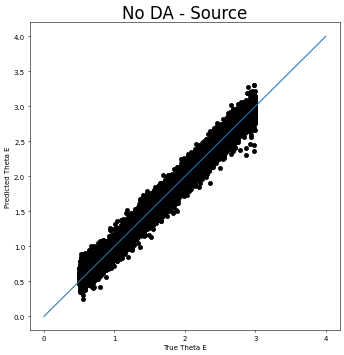

In [27]:
#test on source data
test(dataloader_source_test, NoDAmodel)

-3.4922368079379313


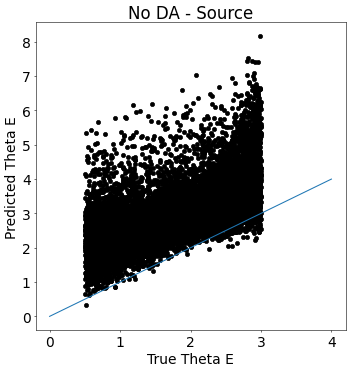

In [28]:
#test on target data
test(dataloader_target_test, NoDAmodel)

DA training

In [29]:
def get_score_da(model, dataloader):
  test_loss, correct = 0, 0
  score_list = np.array([])
  with torch.no_grad():
    for X, y in dataloader:
      X=X.float()
      y=y.float()

      features, outputs=model(X.cuda())

      score = r2_score(y.cpu(), outputs.cpu())
      score_list = np.append(score_list, score)

  score = np.mean(score_list)
  return score

In [30]:
#MMD helper functions
def gaussian_kernel_matrix(x, y, sigmas):
    '''
    Gaussian RBF kernel to be used in MMD
    Args:
    x,y: latent features
    sigmas: free parameter that determins the width of the kernel
    Returns:
    '''
    beta = 1. / (2. * (torch.unsqueeze(sigmas, 1)))
    dist = compute_pairwise_distances(x, y)
    s = torch.matmul(beta, dist.contiguous().view(1, -1))
    return torch.sum(torch.exp(-s), 0).view(*dist.size())


def compute_pairwise_distances(x, y):
    if not x.dim() == y.dim() == 2:
        raise ValueError('Both inputs should be matrices.')
    if x.size(1) != y.size(1):
        raise ValueError('The number of features should be the same.')

    norm = lambda x: torch.sum(torch.pow(x, 2), 1)
    return torch.transpose(norm(torch.unsqueeze(x, 2) - torch.transpose(y, 0, 1)), 0, 1)


def maximum_mean_discrepancy(x, y, kernel=gaussian_kernel_matrix):
    '''
    Calculate the matrix that includes all kernels k(xx), k(y,y) and k(x,y)
    '''
    cost = torch.mean(kernel(x, x))
    cost += torch.mean(kernel(y, y))
    cost -= 2 * torch.mean(kernel(x, y))
    # We do not allow the loss to become negative.
    cost = torch.clamp(cost, min=0.0)
    return cost


def mmd_distance(hs, ht):
    '''
    Maximum Mean Discrepancy - MMD
    Args:
        hs: source domain embeddings
        ht: target domain embeddings
    Returns:
        MMD value
    '''
    sigmas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5,
              10, 15, 20, 25, 30, 35, 100, 1e3, 1e4, 1e5, 1e6]
    gaussian_kernel = partial(gaussian_kernel_matrix,
                              sigmas=torch.Tensor(sigmas).double().to(device))
    loss_value = maximum_mean_discrepancy(hs, ht, kernel=gaussian_kernel)
    return torch.clamp(loss_value, min=1e-4)

In [31]:
def train_da(model, epoch_da, optimizer_da, loss_fn_da, dataloader_source_train, dataloader_target_train, dataloader_source_valid, tr_loss_weight):
  train_examples = len(dataloader_source_train)
  num_train_iterations = train_examples*epoch_da
  num_valid_iterations = len(dataloader_source_valid)
  train_loss=[]
  score_ls=[]
  trans_loss=[]
  tot_loss=[]
  valid_loss_ls=[]
  #training step
  for i in range (0, num_train_iterations):
    model.train(True)

    inputs_train, theta_train = next(iter(dataloader_source_train))
    inputs_train = inputs_train.float()
    theta_train= theta_train.float()
    inputs_train_noisy, theta_train_noisy = next(iter(dataloader_target_train))
    inputs_train_noisy= inputs_train_noisy.float()
    theta_train_noisy=theta_train_noisy.float()

    inputs_train, theta_train, inputs_train_noisy = Variable(inputs_train).to(device), Variable(theta_train).to(device), Variable (inputs_train_noisy).to(device)
    #concat both source and target domain input together for training
    inputs = torch.cat((inputs_train, inputs_train_noisy), dim=0)

    train_batch_size=inputs_train.size(0)

    #features = embeddings, feed into MMD functions later
    features, logits = model(inputs)
    train_logits = logits.narrow(0, 0, train_batch_size)

    #calc MMD loss by inputting embeddings
    transfer_loss = mmd_distance(features[:train_batch_size].double(), features[train_batch_size:].double())
    #regular training loss
    loss = loss_fn(train_logits, theta_train)

    #weight MMD loss by constant
    total_loss = tr_loss_weight * transfer_loss + loss

    # Backward and optimize
    optimizer_da.zero_grad()
    total_loss.backward()
    optimizer_da.step()

    if i % train_examples == 0:

      s=get_score_da(model, dataloader_source_train)
      score_ls.append(s)
      train_loss.append(loss.item())
      tot_loss.append(total_loss.item())
      trans_loss.append(transfer_loss.item())

      #validation step
      for j in range (0, num_valid_iterations):
        model.train(False)
        with torch.no_grad():
          inputs_valid, labels_valid = next(iter(dataloader_source_valid))
          inputs_valid_noisy, labels_valid_noisy = next(iter(dataloader_target_valid))
          inputs_valid=inputs_valid.float()
          labels_valid=labels_valid.float()
          inputs_valid_noisy = inputs_valid_noisy.float()
          inputs_valid, labels_valid = Variable(inputs_valid).cuda(), Variable(labels_valid).cuda()
          inputs_valid_noisy = Variable(inputs_valid_noisy).cuda()
          valid_inputs = torch.cat((inputs_valid, inputs_valid_noisy), dim=0)
          valid_batch_size = inputs_valid.size(0)

          features, logits = model(valid_inputs)
          valid_logits = logits.narrow(0, 0, valid_batch_size)
          transfer_loss = mmd_distance(features[:valid_batch_size].double(), features[valid_batch_size:].double())
          loss = loss_fn(valid_logits,labels_valid)
          valid_total_loss = tr_loss_weight * transfer_loss + loss

        if j % num_valid_iterations == 0:
          valid_loss_ls.append(valid_total_loss.item())


      print('Epoch [{}/{}], training total loss: {:.4f}, valid total loss: {:.4f}, training score: {:.4f}'.format(i/train_examples+1, epoch_da, total_loss.item(), valid_total_loss.item(),s))

  return train_loss, score_ls, trans_loss, total_loss, valid_loss_ls


In [32]:
#hyperparameters
loss_fn = nn.MSELoss().cuda()
optimizer_da = torch.optim.Adam(DAmodel.parameters(), lr=0.00018217008515710942)
epoch_da=100
#note: this weight is from hyperparameter tuning; MMD is very sensitive to hyperparameter changes so changing this could cause MMD to not work
tr_loss_weight =  0.012460473804997567

In [33]:
train_loss, score_ls, trans_loss, total_loss, valid_loss= train_da(DAmodel,epoch_da, optimizer_da, loss_fn, dataloader_source_train, dataloader_target_train, dataloader_source_valid, tr_loss_weight)

Epoch [1.0/100], training total loss: 3.1840, valid total loss: 2.4012, training score: -3.6239
Epoch [2.0/100], training total loss: 0.0362, valid total loss: 0.4440, training score: 0.1661
Epoch [3.0/100], training total loss: 0.0224, valid total loss: 0.4093, training score: 0.2117
Epoch [4.0/100], training total loss: 0.0178, valid total loss: 0.3447, training score: 0.3283
Epoch [5.0/100], training total loss: 0.0152, valid total loss: 0.3129, training score: 0.4305
Epoch [6.0/100], training total loss: 0.0129, valid total loss: 0.2588, training score: 0.4919
Epoch [7.0/100], training total loss: 0.0140, valid total loss: 0.2452, training score: 0.5279
Epoch [8.0/100], training total loss: 0.0101, valid total loss: 0.2002, training score: 0.6180
Epoch [9.0/100], training total loss: 0.0100, valid total loss: 0.2008, training score: 0.6538
Epoch [10.0/100], training total loss: 0.0090, valid total loss: 0.1677, training score: 0.7065
Epoch [11.0/100], training total loss: 0.0100, v

0.9590810412085373


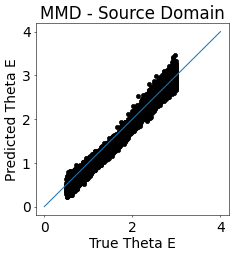

In [34]:
preds = np.array([])
true = np.array([])
score_list=[]
with torch.no_grad():
    for X, y in dataloader_source_test:
        X = X.float()
        f, pred = DAmodel(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

plt.figure(figsize=(5,5), dpi=50)
plt.scatter(true, preds,  color='black')
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD - Source Domain')
print(np.mean(score_list))

0.7006666550645401


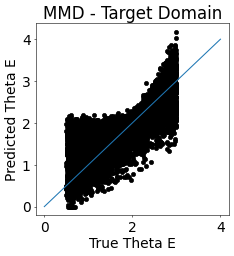

In [35]:
preds = np.array([])
true = np.array([])
score_list=[]
with torch.no_grad():
    for X, y in dataloader_target_test:
        X = X.float()
        f, pred = DAmodel(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

plt.figure(figsize=(5,5), dpi=50)
plt.scatter(true, preds,  color='black')
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD - Target Domain')
print(np.mean(score_list))